In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### initial EDA

<BarContainer object of 2 artists>

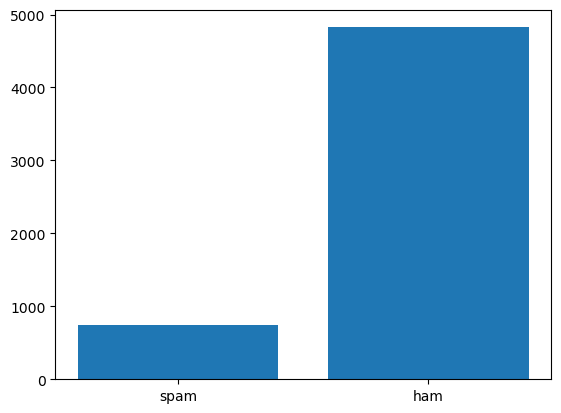

In [9]:
spam = len(df[df['label'] == 'spam'])
ham = len(df[df['label'] == 'ham'])
plt.bar(['spam', 'ham'], [spam, ham])

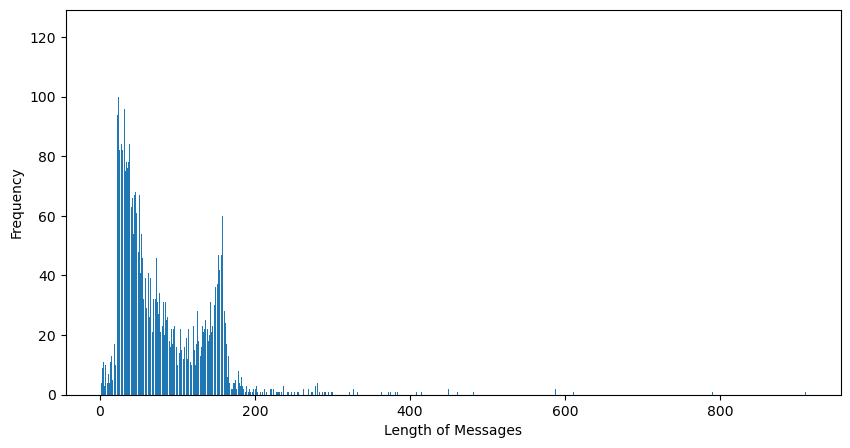

In [13]:
len_of_messages = df['message'].apply(len)
frequency = len_of_messages.value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(frequency.index, frequency.values)
plt.xlabel('Length of Messages')
plt.ylabel('Frequency')
plt.show()

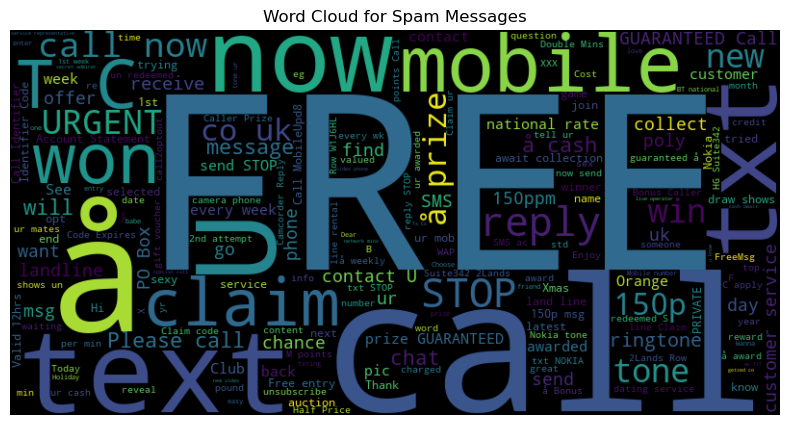

In [24]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df[df['label']=='spam']['message']))
plt.figure(figsize=(10, 5))
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

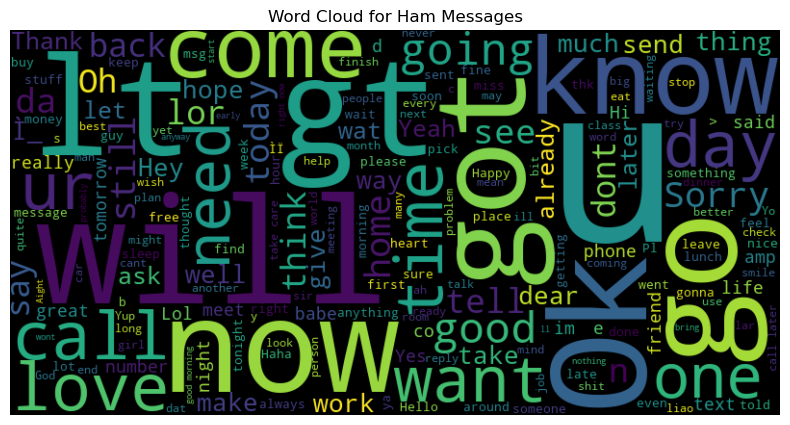

In [26]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df[df['label']=='ham']['message']))
plt.figure(figsize=(10, 5))
plt.title('Word Cloud for Ham Messages')
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

### Data processing

In [27]:
df.isna().sum()

label      0
message    0
dtype: int64

In [31]:
from bs4 import BeautifulSoup
import re
def clean_text(text):
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'\W+', ' ', text) 
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    return text

In [32]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
def process_text(text):
    text = clean_text(text)
    text = text.split()
    text = [word for word in text if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

In [33]:
df['processed_message'] = df['message'].apply(process_text)
df.head()

,label,message,processed_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [35]:
import gensim
from gensim.models import Word2Vec
tokenized_message= df['processed_message'].apply(lambda r: r.split())

w2v = Word2Vec(sentences=tokenized_message, vector_size=100, window=5, min_count=1, workers=4)



In [36]:
import numpy as np
def get_vector(tokens,model):
    vectors = []
    for word in tokens:
        if word in model.wv:
            vectors.append(model.wv[word])

    if not vectors:
        return np.zeros(model.vector_size)

    return np.mean(vectors, axis=0)


In [37]:
X = np.array([get_vector(review, w2v) for review in tokenized_message])

y = df['label']

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.60      0.04      0.07       150

    accuracy                           0.87      1115
   macro avg       0.73      0.52      0.50      1115
weighted avg       0.83      0.87      0.81      1115



In [42]:
# Train a Linear SVM model
from sklearn.calibration import LinearSVC


svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("\nLinear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


Linear SVM Classification Report:
              precision    recall  f1-score   support

         ham       0.92      0.99      0.95       965
        spam       0.85      0.45      0.59       150

    accuracy                           0.92      1115
   macro avg       0.89      0.72      0.77      1115
weighted avg       0.91      0.92      0.90      1115



In [46]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       965
        spam       0.92      0.78      0.84       150

    accuracy                           0.96      1115
   macro avg       0.94      0.88      0.91      1115
weighted avg       0.96      0.96      0.96      1115

